# Bellingham Stormwater Monitoring Analysis

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [338]:
from IPython.display import display, HTML

# Define the CSS to set the height of the output container
css_style = """
<style>
    div.output_area {
        height: 800px; /* Adjust this value based on your needs */
        overflow-y: auto; /* Vertical scroll */
        overflow-x: auto; /* Horizontal scroll */
    }
</style>
"""
# Apply the CSS style to the notebook
display(HTML(css_style))

pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 1000) 

## TODO
1. Review the other site data as well as Bellingham
2. Determine treatment of duplicates
3. Add F chart to show variability.  Review F-Chart calcs from stats book.  Not std
4. Try altair plots (DONE)
5. Research how e.coli data is collected
6. What is variability with time and incubation?
7. Verify that all these tests were taken with similar methods (R-Card, lab, ...).  Comments refer to counts on some measurements which allude to R-Card
8. Convert to plots using Tidy dataset frame and not stack (plotly, or Altair) (DONE)
9. Add column called is_exceedence and calculate counts (see below)



![Bacteria](e.coli-sampling-protocol.png) 

In [339]:
#Original dataset provided by Kirsten McDade on May 28th 2024
dataset1 = 'Salish Sea Stormwater Monitoring Database-20240528.csv'

#Updated dataset provided by Kirsten McDade on Oct 8th 2024
dataset2 = 'Bellingham SW Data_ALL_20241008.csv'

data = pd.read_csv(dataset2)

## Clean raw data

### Clean Dataset1 specific

# Remove 'Unnamed' columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')].dropna(how='all')

# Remove rows with Nan in 'Sample Date' column
data = data.dropna(subset=['Sample Date'])
data = data.rename(columns={'E. Coli': 'E-Coli'}) #This column name causes data plotting weirdness

data.head()

## Clean Dataset2 Specific

In [340]:
data = data.rename(columns={'Survey::Survey_Date': 'Sample Date'})
data = data.rename(columns={'Survey::City': 'City'})
data = data.rename(columns={'Outfall_ID': 'Site ID'})
data = data.rename(columns={'E. coli at 100ml': 'E-Coli'})
data = data.rename(columns={'Enterococcus at 100ml': 'Enterococcus'})

# Convert Sample Date to datetime
data['Sample Date'] = pd.to_datetime(data['Sample Date'])
#data['Sample Date'] = pd.to_datetime(data['Sample Date'], errors='coerce', format='%m-%d-%y')

data.dtypes
data.describe()

#data

,Sample Date,E-Coli,Air Temp,Alkalinity,Color,Cond Exceed Tot,Conductivity,Copper,Copper Exceed Tot,DO,DO Exceedance Tot,E. coli Exceed Tot,Enterococcus,Flouride,Hardness,Hydrogen Sulfide,Iron,Lead,Lead Exceed Tot,Manganese,Mercury,Nitrate,Nitrite,Odor,pH,pH Exceed Tot,Salinity,Sample Vol ML,Sodium Chloride,Temp Exceed Tot,Temp_Difference,Total Chlorine,TotalCount,Turbidity,Turbidity Exceed Tot,UniqueCount,Visual,Water Temp,Zinc
count,565,458.000000,491.000000,146.000000,483.000000,565.0,484.000000,145.000000,565.0,443.000000,565.0,565.0,98.000000,146.000000,145.000000,146.0,146.000000,146.000000,565.0,146.000000,146.000000,143.000000,143.00000,488.000000,487.000000,565.0,486.000000,53.000000,139.000000,565.0,491.000000,135.000000,565.0,475.000000,565.0,565.000000,483.000000,491.000000,145.000000
mean,2023-03-03 12:49:41.946902784,525.532751,14.034460,39.794521,0.480331,164.0,2212.808182,0.010690,8.0,11.167336,30.0,126.0,652.826531,1.589041,86.075862,0.0,0.002055,0.738014,0.0,0.000342,0.000082,0.944056,0.41958,0.178279,7.501561,0.0,1.318745,4.283019,83.453237,175.0,-1.152994,0.103704,565.0,10.723011,6.0,7.900885,0.314700,12.881466,0.896552
min,2020-12-03 00:00:00,0.000000,1.100000,0.000000,0.000000,164.0,0.000000,0.000000,8.0,3.810000,30.0,126.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,5.360000,0.0,0.000000,3.000000,0.000000,175.0,-16.700000,0.000000,565.0,0.000000,6.0,0.018519,0.000000,2.700000,0.000000
25%,2022-05-12 00:00:00,40.000000,8.500000,0.000000,0.000000,164.0,222.000000,0.000000,8.0,9.120000,30.0,126.0,42.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,7.185000,0.0,0.110000,3.000000,0.000000,175.0,-4.250000,0.000000,565.0,4.305000,6.0,2.476190,0.000000,9.300000,0.000000
50%,2023-05-12 00:00:00,127.500000,14.000000,40.000000,0.000000,164.0,322.450000,0.000000,8.0,10.300000,30.0,126.0,165.000000,0.000000,50.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,7.480000,0.0,0.150000,3.000000,0.000000,175.0,-1.600000,0.000000,565.0,9.000000,6.0,5.877193,0.000000,12.700000,0.000000
75%,2024-01-08 00:00:00,375.000000,20.100000,80.000000,1.000000,164.0,855.000000,0.000000,8.0,11.750000,30.0,126.0,400.000000,0.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,7.830000,0.0,0.527500,3.000000,0.000000,175.0,1.255000,0.000000,565.0,9.000000,6.0,13.000000,0.500000,16.200000,0.000000
max,2024-09-17 00:00:00,20480.000000,27.500000,180.000000,3.000000,164.0,42510.000000,0.250000,8.0,114.320000,30.0,126.0,9999.000000,100.000000,425.000000,0.0,0.300000,5.000000,0.0,0.050000,0.002000,60.000000,40.00000,3.000000,8.950000,0.0,27.300000,20.000000,2000.000000,175.0,95.000000,0.500000,565.0,605.000000,6.0,17.000000,3.000000,116.000000,10.000000
std,NaN,1645.472312,6.483533,39.030831,0.667197,0.0,4986.255485,0.045333,0.0,10.153804,0.0,0.0,1540.657973,11.673531,107.814403,0.0,0.024828,1.740574,0.0,0.004138,0.000398,5.690091,3.46494,0.519615,0.489716,0.0,3.045107,4.533539,326.675641,0.0,6.037157,0.203480,0.0,40.576935,0.0,5.460406,0.594172,6.254736,2.256854


In [341]:
# Identify duplicates
duplicates = data[data.duplicated(keep=False)]

data['is_duplicate'] = data.duplicated(subset=['Site ID', 'Sample Date'], keep=False)

# Remove rows with Nan in 'Sample Date' column
#data = data.dropna(subset=['Sample Date'])

#data[data['is_duplicate'] == True].describe()
#data[data['is_duplicate'] == True]

In [342]:
# Add a column called is_execeedence to identify if the E-Coli or Enterococcus values exceed the threshold
bacteria_threshold = 310
data['bacteria_threshold'] = bacteria_threshold

data['is_exceedence'] = False
data.loc[data['E-Coli'] > bacteria_threshold, 'is_exceedence'] = True
data.loc[data['Enterococcus'] > bacteria_threshold, 'is_exceedence'] = True

In [343]:
data.columns

Index(['Sample Date', 'Site ID', 'E-Coli', 'Air Temp', 'Alkalinity',
       'Arrival_Time', 'Bac Notes', 'Color', 'Cond Exceed Tot', 'Conductivity',
       'Copper', 'Copper Exceed Tot', 'DO', 'DO Exceedance Tot',
       'E. coli Exceed Tot', 'Enterococcus', 'Flouride', 'Flow_Rate',
       'Genl_outfall_notes', 'Hardness', 'Hydrogen Sulfide', 'Iron', 'Lead',
       'Lead Exceed Tot', 'Manganese', 'Mercury', 'Nitrate', 'Nitrite', 'Odor',
       'pH', 'pH Exceed Tot', 'QCQA', 'Salinity', 'Sample Vol ML',
       'Sodium Chloride', 'Survey_nbr', 'Temp Exceed Tot', 'Temp_Difference',
       'Total Chlorine', 'TotalCount', 'Turbidity', 'Turbidity Exceed Tot',
       'UniqueCount', 'Vis_Notes', 'Visual', 'Water Temp', 'WQ_Notes',
       'YSI Dupe', 'Zinc', 'City', 'is_duplicate', 'bacteria_threshold',
       'is_exceedence'],
      dtype='object')

In [344]:

#dataset1 specific
#ecoli = data[['Sample Date', 'Site ID', 'E-Coli', 'Comments', 'is_duplicate', 'is_exceedence', 'bacteria_threshold']].copy()
#dataset2 specific
ecoli = data[['Sample Date', 'Site ID', 'E-Coli', 'is_duplicate', 'is_exceedence', 'bacteria_threshold']].copy()

# Extract the month for aggregation in ecoli
ecoli['Month'] = ecoli['Sample Date'].dt.to_period('M')  # Convert date to month period for grouping

# Re-format the 'Month' column to a proper datetime format
#ecoli['Month'] = pd.to_timestamp(ecoli['Month'])

#dataset 1 specific
#enterococcus = data[['Sample Date', 'Site ID', 'Enterococcus', 'Comments', 'is_duplicate', 'is_exceedence', 'bacteria_threshold']].copy()
#dataset2 specific
enterococcus = data[['Sample Date', 'Site ID', 'Enterococcus', 'is_duplicate', 'is_exceedence', 'bacteria_threshold']].copy()


# Extract the month for aggregation in ecoli
enterococcus['Month'] = enterococcus['Sample Date'].dt.to_period('M')  # Convert date to month period for grouping

# Sort data by date
ecoli = ecoli.sort_values('Sample Date')
enterococcus = enterococcus.sort_values('Sample Date')

#ecoli.dtypes
#ecoli

Save Dataframe for use in GPT optimization

In [345]:
ecoli.to_csv("ecoli.csv")

In [346]:
ecoli.site_id = 'Bennett Ave'

## Clean Data

In [347]:

ecoli_data_clean = ecoli.dropna(subset=['E-Coli']).copy()

# Re-format the 'Month' column to a proper datetime format and then to string
ecoli_data_clean['Month'] = ecoli_data_clean['Month'].dt.to_timestamp()

#ecoli_data_clean[ecoli_data_clean['Month'] == '2021-09-01']
#ecoli_data_clean

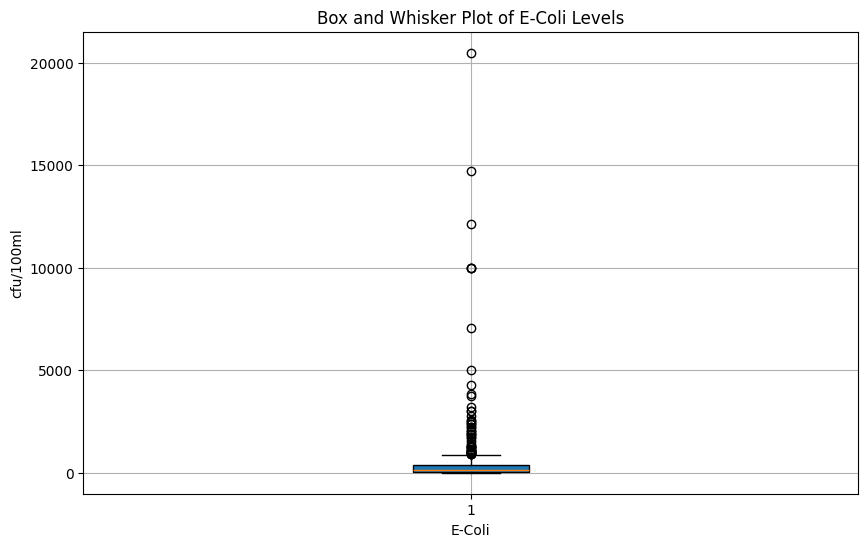

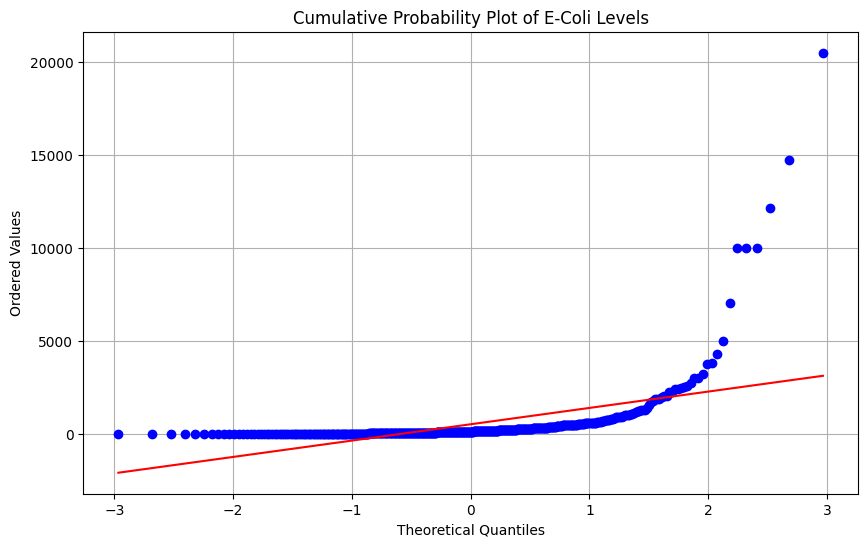

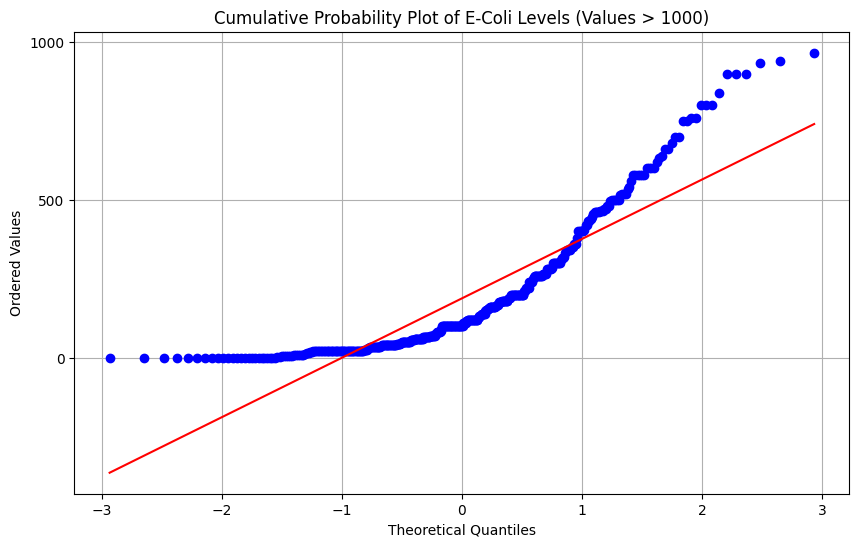

In [348]:
import scipy.stats as stats
from matplotlib.ticker import MultipleLocator

#plot a box and whisker plot of the e-coli collumn of the ecoli_data_clean dataframe
plt.figure(figsize=(10, 6))
plt.boxplot(ecoli_data_clean['E-Coli'].dropna(), vert=True, patch_artist=True)
plt.title('Box and Whisker Plot of E-Coli Levels')
plt.xlabel('E-Coli')
plt.ylabel('cfu/100ml')
plt.grid(True)
plt.show()

# Plot a cumulative probability plot of the 'E-Coli' column
plt.figure(figsize=(10, 6))
stats.probplot(ecoli_data_clean['E-Coli'].dropna(), dist="norm", plot=plt)
plt.title('Cumulative Probability Plot of E-Coli Levels')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.grid(True)
plt.show()

# Plot a cumulative probability plot of the filtered 'E-Coli' column
plt.figure(figsize=(10, 6))
stats.probplot(ecoli_data_clean['E-Coli'][ecoli_data_clean['E-Coli'] < 1000].dropna(), dist="norm", plot=plt)
plt.title('Cumulative Probability Plot of E-Coli Levels (Values > 1000)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.grid(True)
plt.gca().yaxis.set_major_locator(MultipleLocator(500))  # Set y-axis grid interval to 100
plt.show()

## Filter and Aggregate Data
Concerntrate on recent data > 2021

Remove outliers which skew the baseline

Aggregate data for the same month using geometric mean

In [349]:
from scipy.stats import gmean

#Aggregate data for the same month using geometric mean
# Group by 'Site ID' and 'Month' and calculate geometric mean
grouped_data = ecoli_data_clean.groupby(['Site ID', 'Month']).agg({
    'E-Coli': lambda x: gmean(x[x > 0]),  # Geometric mean, ignoring non-positive values
}).reset_index()

#grouped_data[grouped_data['Month'] == '2021-09-01']
#grouped_data.duplicated(subset=['Site ID', 'Month'])

/var/folders/_s/jtjh9qbn6m7c74p0ybbm9jbh0000gn/T/ipykernel_18050/911947433.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'E-Coli': lambda x: gmean(x[x > 0]),  # Geometric mean, ignoring non-positive values


Determine the appropriate range for CFU/ml.  Counts above 250 are considered Too Numerous To Count (TNTC) because it is impossible to tell whether colonies are separated (https://wic.oregonstate.edu/microbiology-writing-guide-presenting-data)

In [350]:
start_date = pd.Timestamp('2021-01-01')
#filtered_data = ecoli_data_clean[ecoli_data_clean['Month'] >= start_date]
filtered_data = grouped_data

#Filter for site id = Bennett Ave  
#filtered_data = filtered_data[filtered_data['Site ID'] == 'Bennett Ave']

#Filter e-coli values greater than 5000
#filtered_data = filtered_data[filtered_data['E-Coli'] <= 5000]

#show unique site ids
site_ids = ecoli_data_clean['Site ID'].unique()
site_ids


array(['Bennett Ave', 'C St', 'Squalicum Creek', 'Cedar St', 'Olive St',
       'Broadway St', 'Cornwall St', 'Whatcom Creek', 'Padden Creek',
       'Little Squalicum Creek', 'Willow St', 'G06-1001', 'G05-1002',
       'G11-1001', 'Cedar'], dtype=object)

What's up with G06-1001, G05-1002, and G11-1011 site ids?

## Visualize

In [351]:
# Create a selection for the dropdown
#site_id_dropdown = alt.binding_select(options=filtered_data['Site ID'].unique(), name='Site ID')
#site_id_select = alt.selection_point(fields=['Site ID'], bind=site_id_dropdown, value={'Site ID': filtered_data['Site ID'].unique()[0]})

# Base chart
chart = alt.Chart(filtered_data).mark_line(point=True).encode(
    x='Month:T',
    y=alt.Y('E-Coli:Q', scale=alt.Scale(domain=[0, 20000])),  # Set y-axis limit
    color='Site ID:N',
    tooltip=['Month:T', 'Site ID:N', 'E-Coli:Q']
).properties(
    title='E. Coli Measurements by Month for Each Site ID',
    width=800,
    height=400
#).add_selection(
#    site_id_select
#).transform_filter(
#    site_id_select
).interactive()

# Horizontal line at y=320
horizontal_line = alt.Chart(pd.DataFrame({'y': [320]})).mark_rule(
    color='red',
    strokeDash=[5, 5]
).encode(
    y='y:Q'
)

line_chart = chart + horizontal_line

# Histogram of E-Coli
histogram = alt.Chart(filtered_data).mark_bar().encode(
    x=alt.X('E-Coli:Q', bin=alt.Bin(step=50)),
    y='count()',
    color='Site ID:N'
).properties(
    title='Histogram of E. Coli Measurements',
    width=800,
    height=200
)

# Combine the line chart and histogram
final_chart = alt.vconcat(line_chart, histogram)

final_chart.show()



alt.VConcatChart(...)

In [352]:
#Second Filter e-coli values greater than 1000
filtered_data = filtered_data[filtered_data['E-Coli'] <= 1000]

# Histogram of E-Coli with bin size 50, faceted by Site ID
histogram = alt.Chart(filtered_data).mark_bar().encode(
    x=alt.X('E-Coli:Q', bin=alt.Bin(step=50)),
    y='count()',
    color='Site ID:N'
).properties(
    title='E. Coli Histogram',
    width=200,
    height=200
).facet(
    column='Site ID:N'
)

histogram.show()

alt.FacetChart(...)

### Matplotlib Visulazation

/var/folders/_s/jtjh9qbn6m7c74p0ybbm9jbh0000gn/T/ipykernel_18050/1783387904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_data['E-Coli Moving Average'] = site_data['E-Coli'].rolling(window=4).mean()


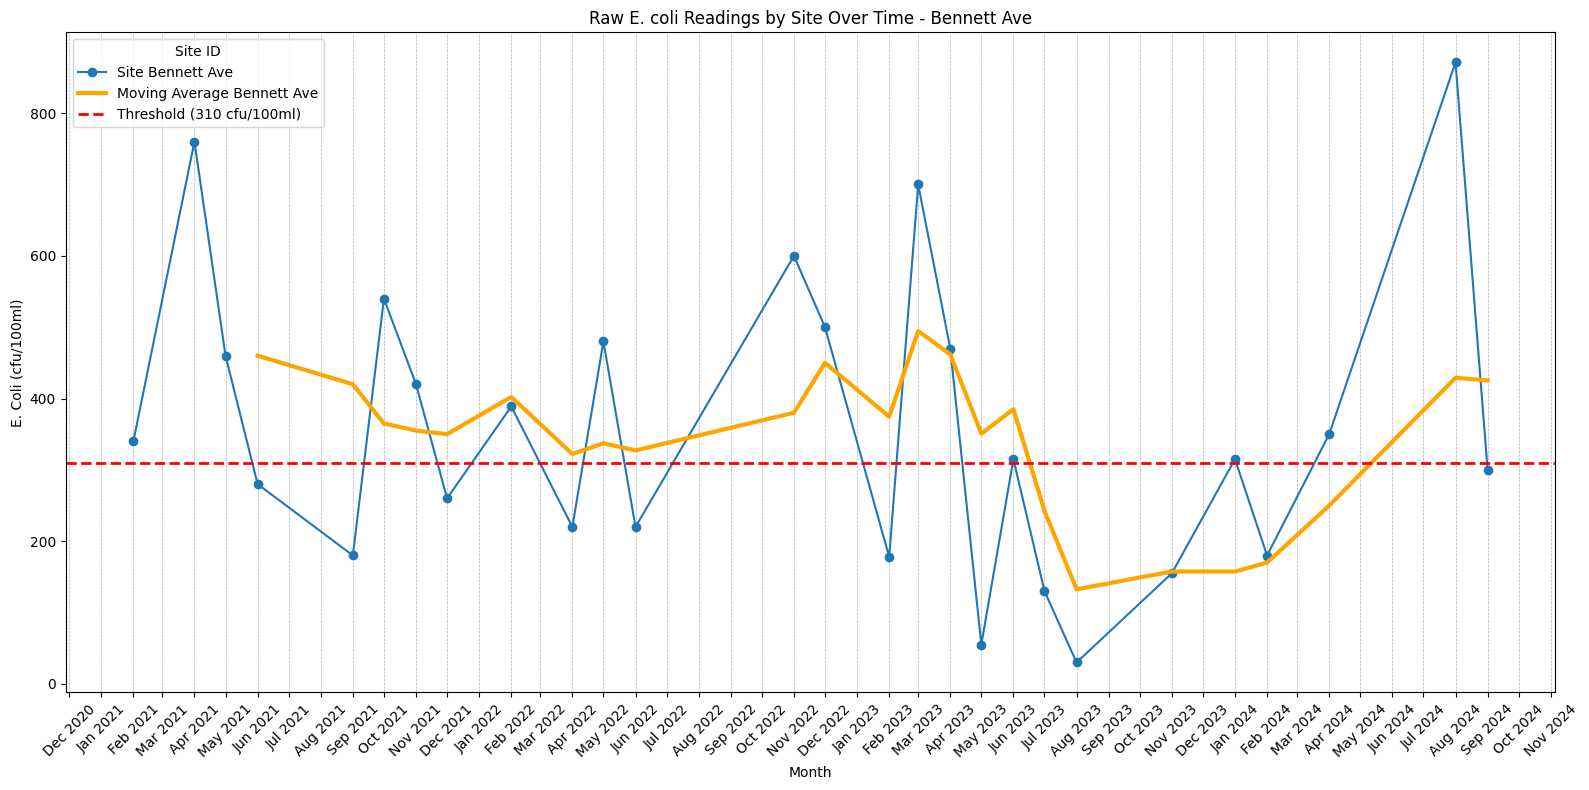

In [354]:
import matplotlib.dates as mdates

site_data = filtered_data[filtered_data['Site ID'] == 'Bennett Ave']

# Calculate the moving average (window size of 5 for example)
site_data['E-Coli Moving Average'] = site_data['E-Coli'].rolling(window=4).mean()

fig, ax = plt.subplots(figsize=(16, 8))
for site_id, group in site_data.groupby('Site ID'):
    ax.plot(group['Month'], group['E-Coli'], marker='o', linestyle='-', label=f'Site {site_id}')
    ax.plot(group['Month'], group['E-Coli Moving Average'], marker='', linestyle='-', linewidth=3, color='orange', label=f'Moving Average {site_id}')

# Set the major locator and formatter for the x-axis to show every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add vertical grid lines for each month
ax.grid(which='major', axis='x', linestyle='--', linewidth=0.5)

ax.set_title('Raw E. coli Readings by Site Over Time - Bennett Ave')
ax.set_xlabel('Month')
ax.set_ylabel('E. Coli (cfu/100ml)')
ax.axhline(y=bacteria_threshold, color='red', linewidth=2, linestyle='--', label='Threshold (310 cfu/100ml)')
ax.legend(title='Site ID')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

#site_data

Bennett Ave Data has mnay outliers 

/var/folders/_s/jtjh9qbn6m7c74p0ybbm9jbh0000gn/T/ipykernel_18050/136297745.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='Site ID')


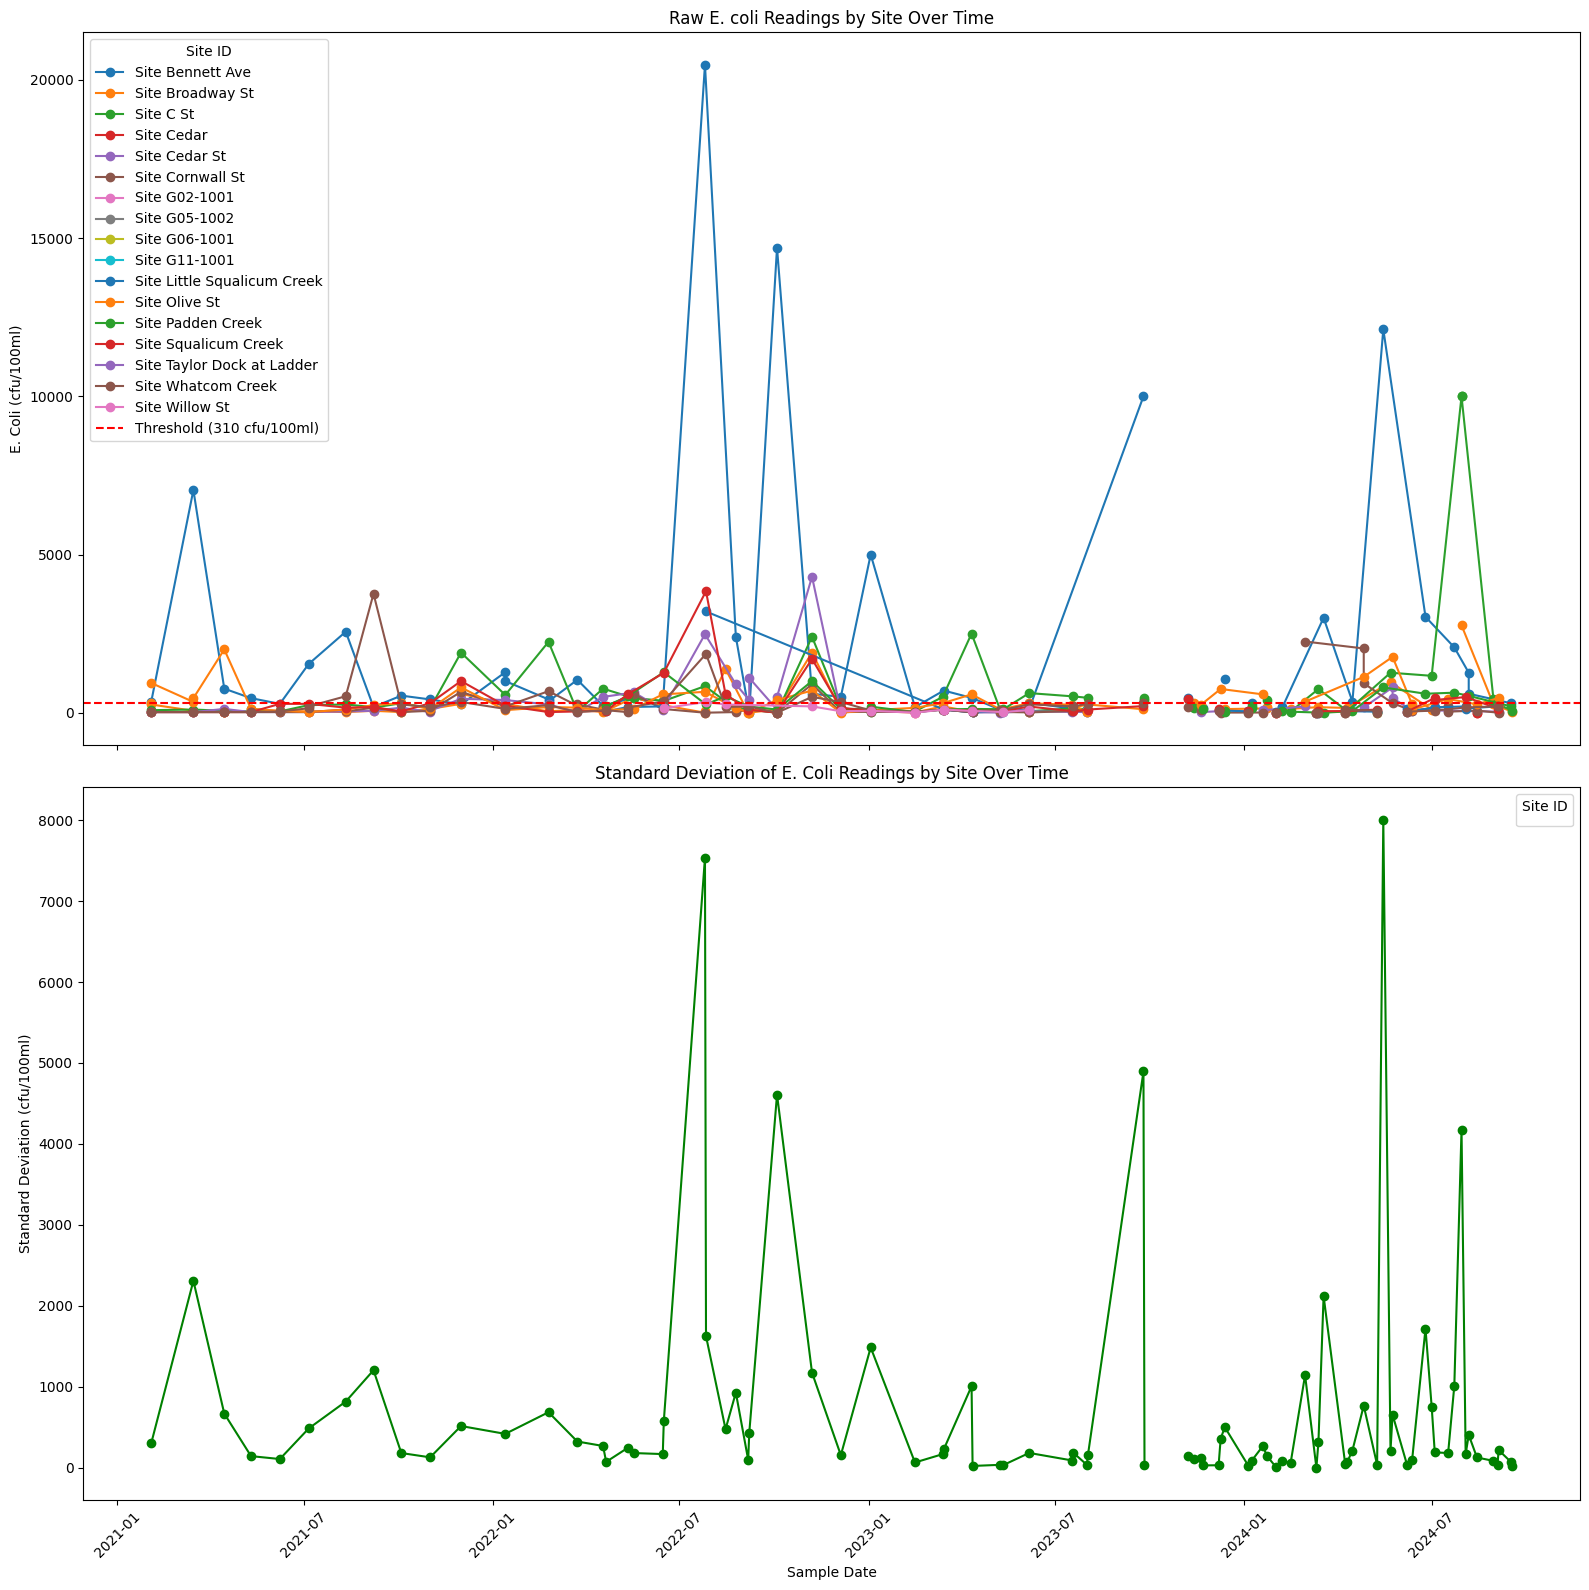

In [305]:
# Create a figure with two subplots (ax for raw readings and ax2 for variability F-chart)
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), sharex=True)

# Plotting E. Coli readings by Site
for site_id, group in ecoli.groupby('Site ID'):
    ax.plot(group['Sample Date'], group['E-Coli'], marker='o', linestyle='-', label=f'Site {site_id}')

ax.set_title('Raw E. coli Readings by Site Over Time')
ax.set_ylabel('E. Coli (cfu/100ml)')
ax.axhline(y=310, color='red', linestyle='--', label='Threshold (310 cfu/100ml)')
ax.legend(title='Site ID')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Plotting F-chart of variability (Standard Deviation over time)
# Calculating standard deviation for each date
std_dev_by_date = ecoli.groupby('Sample Date')['E-Coli'].std()
ax2.plot(std_dev_by_date.index, std_dev_by_date, marker='o', linestyle='-', color='green')

# Plotting F-chart of variability (Standard Deviation over time) by Site ID

#for site_id, group in ecoli.groupby('Site ID'):
#    std_dev = group.groupby('Sample Date')['E. Coli'].std()
#    ax2.plot(std_dev.index, std_dev, marker='o', linestyle='-', label=f'Site {site_id}')

ax2.set_title('Standard Deviation of E. Coli Readings by Site Over Time')
ax2.set_xlabel('Sample Date')
ax2.set_ylabel('Standard Deviation (cfu/100ml)')
ax2.legend(title='Site ID')

plt.tight_layout()
plt.show()

In [306]:
ecoli[ecoli['Site ID'] == 'Bennett Ave']

,Sample Date,Site ID,E-Coli,is_duplicate,is_exceedence,bacteria_threshold,Month
0,2021-02-03,Bennett Ave,340.0,False,True,310,2021-02
1,2021-03-16,Bennett Ave,7040.0,False,True,310,2021-03
2,2021-04-15,Bennett Ave,760.0,False,True,310,2021-04
3,2021-05-11,Bennett Ave,460.0,False,True,310,2021-05
4,2021-06-08,Bennett Ave,280.0,False,False,310,2021-06
5,2021-07-06,Bennett Ave,1540.0,False,True,310,2021-07
6,2021-08-11,Bennett Ave,2560.0,False,True,310,2021-08
7,2021-09-07,Bennett Ave,180.0,False,False,310,2021-09
8,2021-10-04,Bennett Ave,540.0,False,True,310,2021-10
9,2021-11-01,Bennett Ave,420.0,False,True,310,2021-11


In [307]:
# Aggregate data for plotting
ecoli_aggregated_mean = ecoli.groupby(['Month', 'Site ID'])['E-Coli'].mean().unstack()
ecoli_aggregated_std = ecoli.groupby(['Month', 'Site ID'])['E-Coli'].std().unstack()
enterococcus_aggregated = enterococcus.groupby(['Month', 'Site ID'])['Enterococcus'].mean().unstack()

In [308]:
ecoli_aggregated_mean
#ecoli_aggregated[ecoli_aggregated['Site ID'] == 'Bennett Ave']

Site ID,Bennett Ave,Broadway St,C St,Cedar,Cedar St,Cornwall St,G02-1001,G05-1002,G06-1001,G11-1001,Little Squalicum Creek,Olive St,Padden Creek,Squalicum Creek,Taylor Dock at Ladder,Whatcom Creek,Willow St
Month,,,,,,,,,,,,,,,,,
2020-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02,340.0,280.0,80.000000,NaN,20.0,20.0,NaN,NaN,NaN,NaN,NaN,940.0,NaN,20.0,NaN,20.0,NaN
2021-03,7040.0,60.0,100.000000,NaN,20.0,20.0,NaN,NaN,NaN,NaN,NaN,400.0,NaN,20.0,NaN,20.0,NaN
2021-04,760.0,20.0,60.000000,NaN,120.0,20.0,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,20.0,NaN,20.0,NaN
2021-05,460.0,40.0,80.000000,NaN,20.0,20.0,NaN,NaN,NaN,NaN,NaN,120.0,NaN,20.0,NaN,20.0,NaN
2021-06,280.0,60.0,40.000000,NaN,20.0,20.0,NaN,NaN,NaN,NaN,NaN,60.0,NaN,280.0,NaN,40.0,NaN
2021-07,1540.0,40.0,240.000000,NaN,20.0,20.0,NaN,NaN,NaN,NaN,NaN,20.0,NaN,280.0,NaN,170.0,NaN
2021-08,2560.0,20.0,260.000000,NaN,40.0,70.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,160.0,NaN,520.0,NaN
2021-09,180.0,60.0,170.000000,NaN,60.0,160.0,NaN,NaN,NaN,NaN,NaN,240.0,NaN,180.0,NaN,3760.0,NaN


In [309]:
ecoli_threshold = 310
enterococcus_threshold = 500

<Axes: title={'center': 'Std Dev of E. Coli Readings'}, xlabel='Month'>

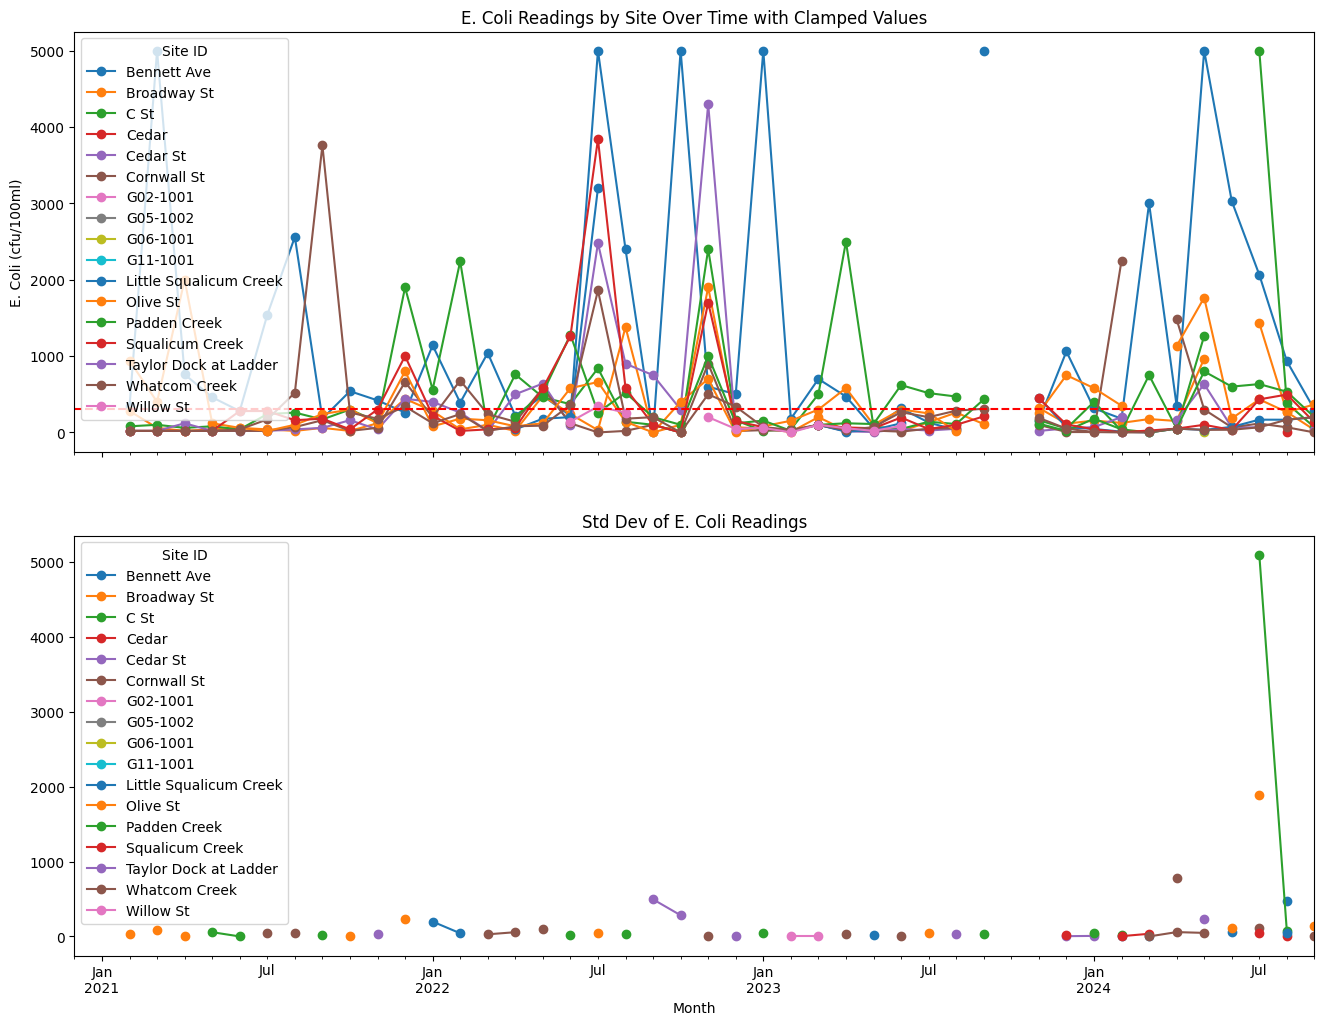

In [310]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
ecoli_aggregated_mean.clip(upper=5000).plot(ax=ax[0], marker='o', linestyle='-', title='E. Coli Readings by Site Over Time with Clamped Values')
ax[0].set_ylabel('E. Coli (cfu/100ml)')
ax[0].axhline(y=ecoli_threshold, color='red', linestyle='--', label='E. Coli Threshold (cfu/100ml)')
ecoli_aggregated_std.plot(ax=ax[1], marker='o', linestyle='-', title='Std Dev of E. Coli Readings')

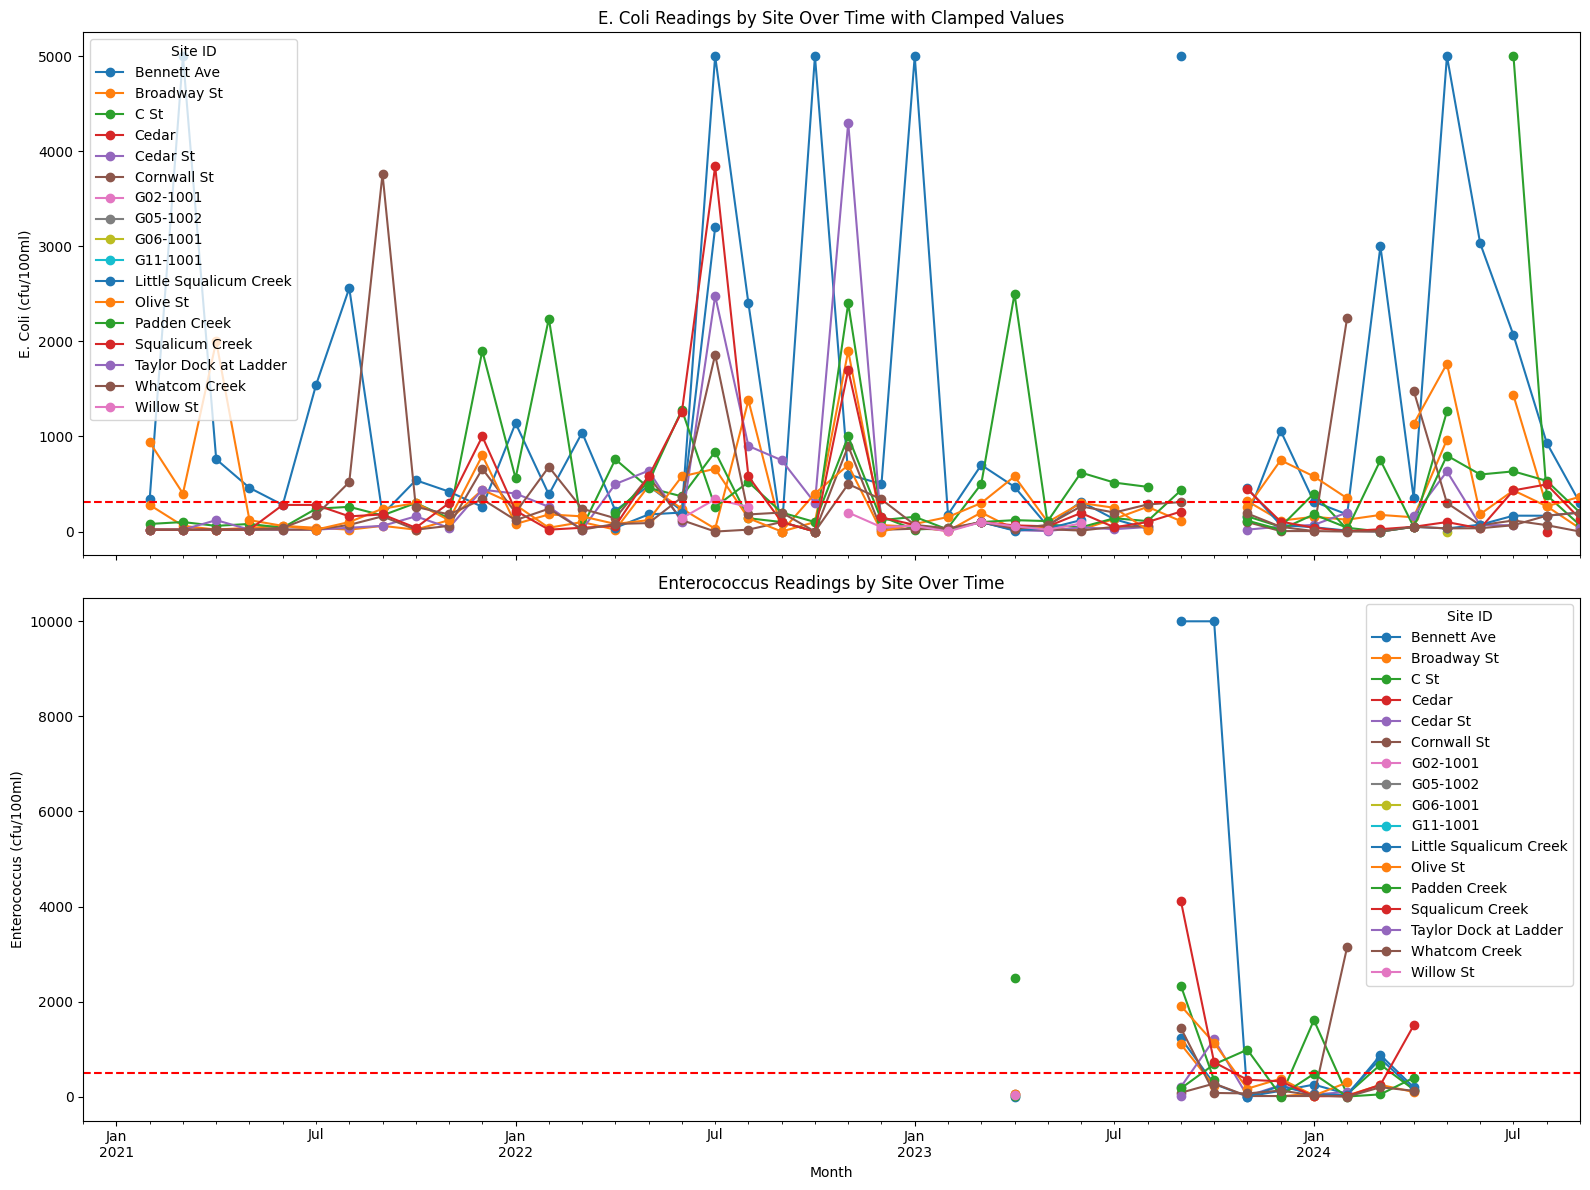

In [311]:
# Plotting the control charts
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
ecoli_aggregated_mean.clip(upper=5000).plot(ax=ax[0], marker='o', linestyle='-', title='E. Coli Readings by Site Over Time with Clamped Values')
ax[0].set_ylabel('E. Coli (cfu/100ml)')
ax[0].axhline(y=ecoli_threshold, color='red', linestyle='--', label='E. Coli Threshold (cfu/100ml)')
enterococcus_aggregated.plot(ax=ax[1], marker='o', linestyle='-', title='Enterococcus Readings by Site Over Time')
ax[1].set_ylabel('Enterococcus (cfu/100ml)')
ax[1].axhline(y=enterococcus_threshold, color='red', linestyle='--', label='Enterococcus Threshold (cfu/100ml)')
plt.tight_layout()
plt.show()

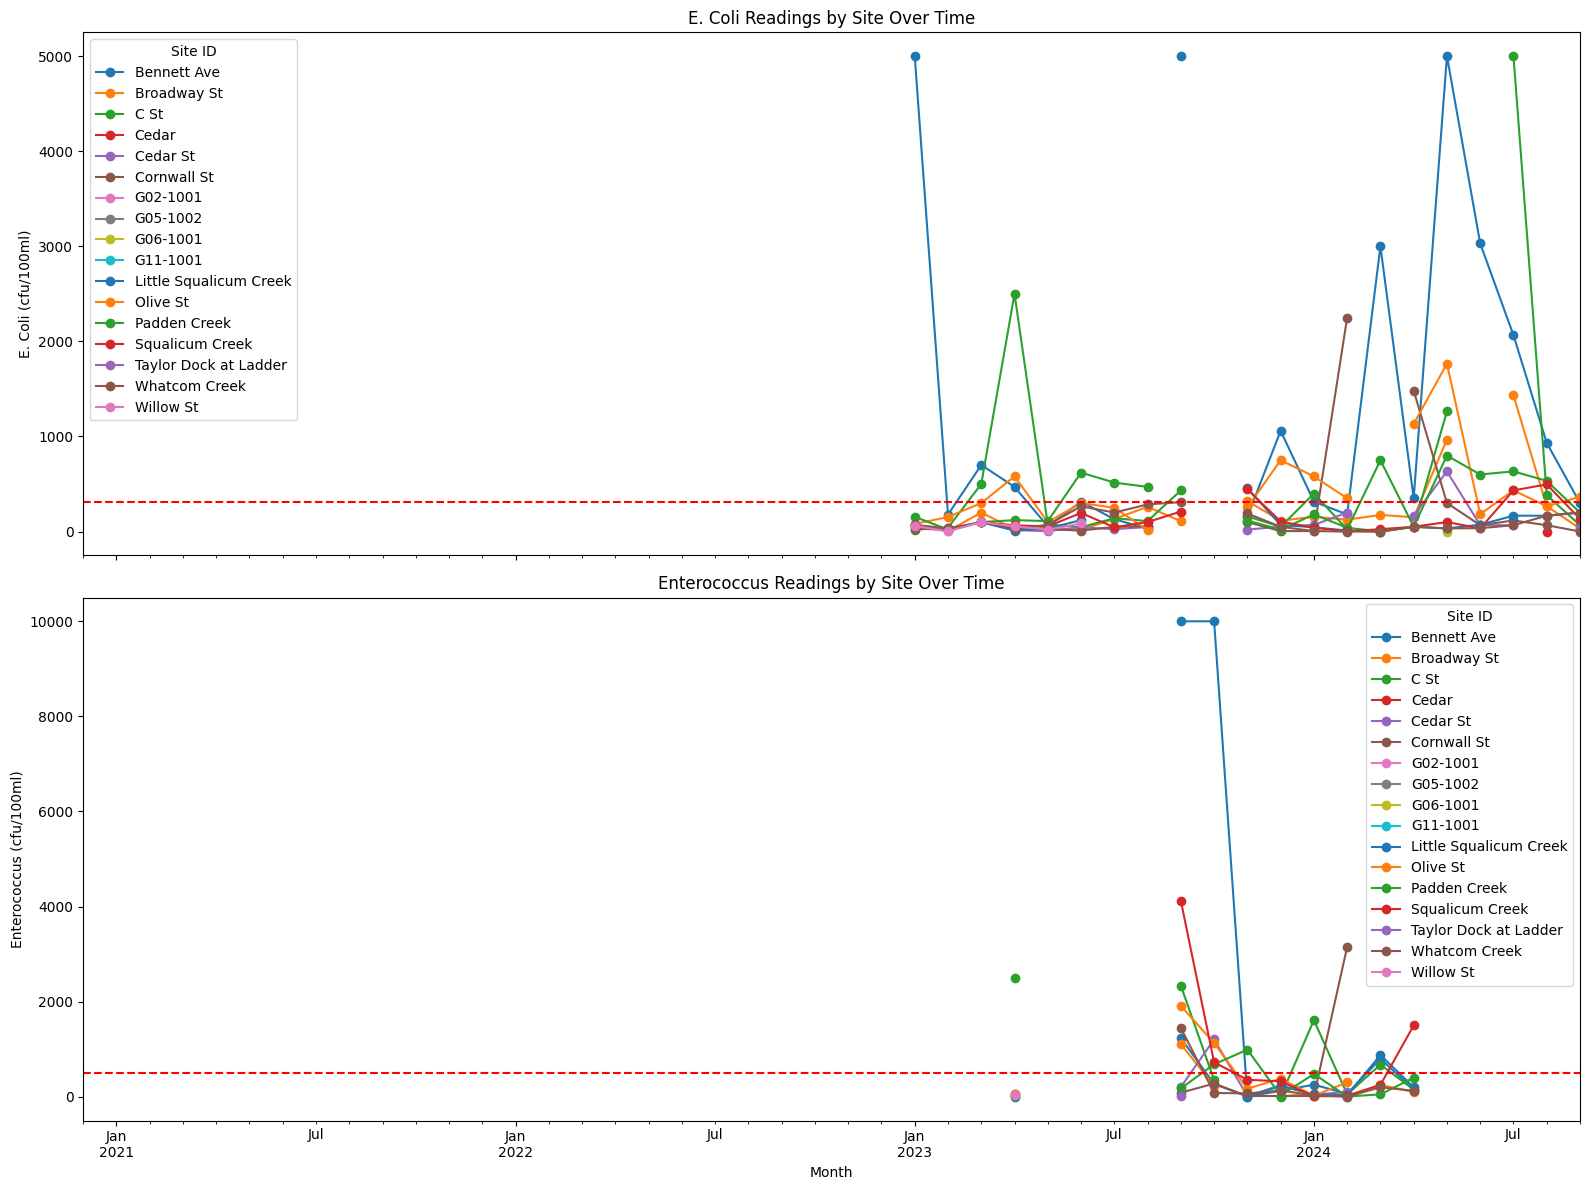

In [312]:
ecoli_aggregated_mean = ecoli_aggregated_mean[ecoli_aggregated_mean.index >= '2023-01']
enterococcus_aggregated_mean = enterococcus_aggregated[enterococcus_aggregated.index >= '2023-01']

fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
ecoli_aggregated_mean.clip(upper=5000).plot(ax=ax[0], marker='o', linestyle='-', title='E. Coli Readings by Site Over Time')
ax[0].set_ylabel('E. Coli (cfu/100ml)')
ax[0].axhline(y=ecoli_threshold, color='red', linestyle='--', label='E. Coli Threshold (cfu/100ml)')
enterococcus_aggregated.plot(ax=ax[1], marker='o', linestyle='-', title='Enterococcus Readings by Site Over Time')
ax[1].set_ylabel('Enterococcus (cfu/100ml)')
ax[1].axhline(y=enterococcus_threshold, color='red', linestyle='--', label='Enterococcus Threshold (cfu/100ml)')

plt.tight_layout()
plt.show()

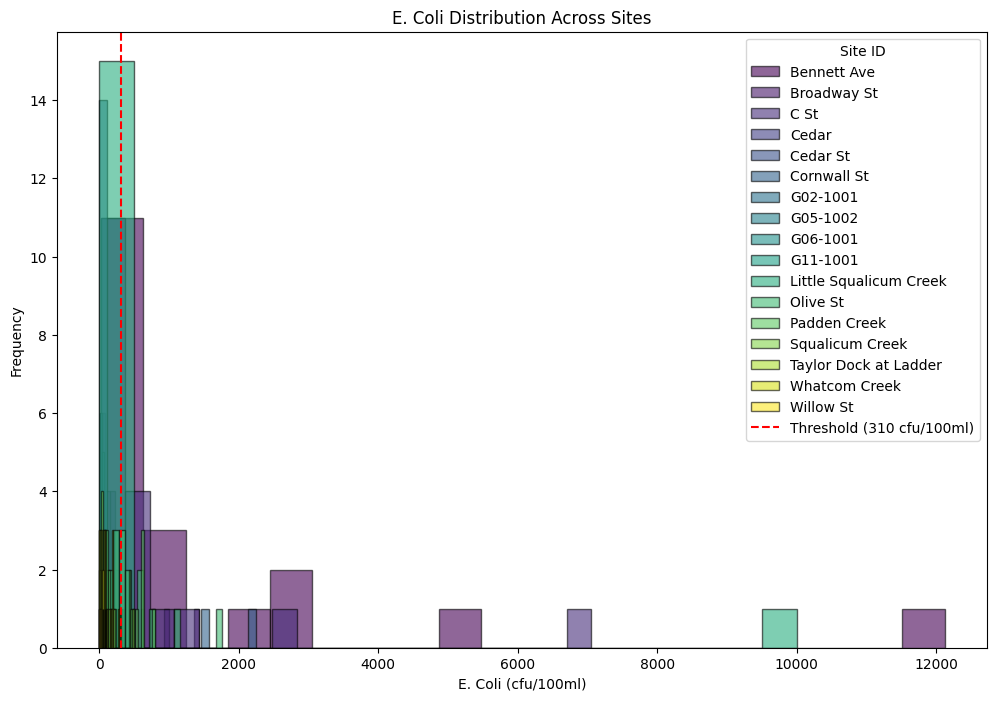

In [313]:
# Generate histograms
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(ecoli_aggregated_mean.columns)))

for (site, values), color in zip(ecoli_aggregated_mean.items(), colors):
    ax.hist(values.dropna(), bins=20, color=color, alpha=0.6, edgecolor='black', label=site)

ax.axvline(x=ecoli_threshold, color='red', linestyle='--', label='Threshold (310 cfu/100ml)')
ax.set_title('E. Coli Distribution Across Sites')
ax.set_xlabel('E. Coli (cfu/100ml)')
ax.set_ylabel('Frequency')
ax.legend(title='Site ID')
plt.show()

In [314]:
# Calculate exceedances for E. coli
ecoli_exceedances = ecoli[ecoli['E-Coli'] > ecoli_threshold]
ecoli_exceedances['Year'] = ecoli_exceedances['Sample Date'].dt.year
exceedance_counts = ecoli_exceedances.groupby(['Year', 'Site ID']).size().reset_index(name='Exceedance Count')
total_counts = ecoli.groupby([ecoli['Sample Date'].dt.year, 'Site ID']).size().reset_index(name='Total Readings')
total_counts.rename(columns={'Sample Date': 'Year'}, inplace=True)
exceedance_data = pd.merge(total_counts, exceedance_counts, on=['Year', 'Site ID'], how='left').fillna(0)
exceedance_data['Exceedance Percentage'] = (exceedance_data['Exceedance Count'] / exceedance_data['Total Readings']) * 100

print(exceedance_data)

    Year                 Site ID  Total Readings  Exceedance Count  \
0   2020                    C St               1               0.0   
1   2020                Cedar St               1               0.0   
2   2021             Bennett Ave              11               8.0   
3   2021             Broadway St              15               1.0   
4   2021                    C St              14               1.0   
5   2021                Cedar St              12               1.0   
6   2021             Cornwall St              12               1.0   
7   2021                Olive St              12               5.0   
8   2021         Squalicum Creek              11               1.0   
9   2021           Whatcom Creek              12               3.0   
10  2022             Bennett Ave              14              11.0   
11  2022             Broadway St              13               3.0   
12  2022                    C St              14               8.0   
13  2022            

/var/folders/_s/jtjh9qbn6m7c74p0ybbm9jbh0000gn/T/ipykernel_18050/369896904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecoli_exceedances['Year'] = ecoli_exceedances['Sample Date'].dt.year
